In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't4_innerRadius',
    't4_outerRadius',
    't4_pt',
    't4_eta',
    't4_phi',
    't4_isFake',
    't4_t3_idx0',
    't4_t3_idx1',
    't4_pMatched'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't4_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "t4_PU200_175.root"
branches = load_root_file(file_path, branches_list)

In [2]:
z_max = np.max([np.max(event) for event in branches[f't4_t3_4_z'] if event.size>0])
r_max = np.max([np.max(event) for event in branches[f't4_t3_4_r'] if event.size>0])
eta_max = 2.5

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []
eta_list = [] # Used for DNN cut values

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t4_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t4_t3_idx0'][event][i]
        idx1 = branches['t4_t3_idx1'][event][i] 

        # Collect features using idx0
        features_iter.extend([
            np.abs(branches['t4_t3_0_eta'][event][idx0]) / eta_max,
            np.abs(branches['t4_t3_0_z'][event][idx0]) / z_max,
            branches['t4_t3_0_r'][event][idx0] / r_max,
            np.abs(branches['t4_t3_2_eta'][event][idx0]) - np.abs(branches['t4_t3_0_eta'][event][idx0]),
            (np.abs(branches['t4_t3_2_z'][event][idx0]) - np.abs(branches['t4_t3_0_z'][event][idx0])) / z_max,
            (branches['t4_t3_2_r'][event][idx0] - branches['t4_t3_0_r'][event][idx0]) / r_max,
            np.abs(branches['t4_t3_4_eta'][event][idx0]) - np.abs(branches['t4_t3_2_eta'][event][idx0]),
            (np.abs(branches['t4_t3_4_z'][event][idx0]) - np.abs(branches['t4_t3_2_z'][event][idx0])) / z_max,
            (branches['t4_t3_4_r'][event][idx0] - branches['t4_t3_2_r'][event][idx0]) / r_max,
        ])
        
        # Collect features using idx1
        features_iter.extend([
            # np.abs(branches['t4_t3_2_eta'][event][idx1]) - np.abs(branches['t4_t3_4_eta'][event][idx0]),
            # (np.abs(branches['t5_t3_2_z'][event][idx1]) - np.abs(branches['t5_t3_4_z'][event][idx0])) / z_max,
            # (branches['t5_t3_2_r'][event][idx1] - branches['t5_t3_4_r'][event][idx0]) / r_max,
            np.abs(branches['t4_t3_4_eta'][event][idx1]) - np.abs(branches['t4_t3_2_eta'][event][idx1]),
            (np.abs(branches['t4_t3_4_z'][event][idx1]) - np.abs(branches['t4_t3_2_z'][event][idx1])) / z_max,
            (branches['t4_t3_4_r'][event][idx1] - branches['t4_t3_2_r'][event][idx1]) / r_max,
        ])
        
        # Add remaining features
        features_iter.extend([
            np.log10(branches['t4_innerRadius'][event][i]),
            np.log10(branches['t4_outerRadius'][event][i]),
            np.log10((branches['t4_innerRadius'][event][i])/(branches['t4_outerRadius'][event][i])),
        ])

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t4_t3_0_eta'][event][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t4_isFake_filtered = np.concatenate(branches['t4_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize model, loss function, and optimizer
model = MyNeuralNetwork().to(device)
loss_function = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.0025)

labels_tensor = 1 - torch.tensor(t4_isFake_filtered, dtype=torch.float32)

# Remove rows with NaN in input_features_tensor and corresponding labels
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Get indices of each class
class_zero_indices = (filtered_labels == 0).nonzero(as_tuple=True)[0]
class_one_indices = (filtered_labels == 1).nonzero(as_tuple=True)[0]

print(np.shape(class_zero_indices), np.shape(class_one_indices))

# Randomly sample from the majority class to match the number of samples in the minority class
undersampled_class_one_indices = class_one_indices[torch.randperm(len(class_one_indices))[:len(class_zero_indices)]]

# Combine the minority class indices with the downsampled majority class indices
undersampled_indices = torch.cat((class_zero_indices, undersampled_class_one_indices), dim=0)

# Create new dataset with undersampled indices
undersampled_dataset = TensorDataset(filtered_inputs[undersampled_indices], filtered_labels[undersampled_indices])

total_count = len(undersampled_dataset)
train_count = int(0.8 * total_count)  # 80% for training
test_count = total_count - train_count  # Remaining 20% for testing

train_dataset, test_dataset = random_split(undersampled_dataset, [train_count, test_count])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)
loss_log = []

def evaluate_model(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5
            total += targets.size(0)
            correct += (predicted == targets.bool()).sum().item()
    model.train()
    return 100 * correct / total

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
    
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs.squeeze(), targets)

        loss_log.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_accuracy = evaluate_model(train_loader)
    test_accuracy = evaluate_model(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Using device: cuda
torch.Size([4727758]) torch.Size([51350])
Epoch [1/200], Loss: 0.0453, Train Acc: 99.03%, Test Acc: 99.02%
Epoch [2/200], Loss: 0.0355, Train Acc: 99.03%, Test Acc: 99.02%
Epoch [3/200], Loss: 0.0291, Train Acc: 99.07%, Test Acc: 99.06%
Epoch [4/200], Loss: 0.0270, Train Acc: 99.08%, Test Acc: 99.07%
Epoch [5/200], Loss: 0.0374, Train Acc: 99.07%, Test Acc: 99.05%
Epoch [6/200], Loss: 0.0537, Train Acc: 99.09%, Test Acc: 99.07%
Epoch [7/200], Loss: 0.0584, Train Acc: 99.08%, Test Acc: 99.07%
Epoch [8/200], Loss: 0.0218, Train Acc: 99.08%, Test Acc: 99.07%
Epoch [9/200], Loss: 0.0376, Train Acc: 99.07%, Test Acc: 99.06%
Epoch [10/200], Loss: 0.0309, Train Acc: 99.10%, Test Acc: 99.09%
Epoch [11/200], Loss: 0.0411, Train Acc: 99.09%, Test Acc: 99.09%
Epoch [12/200], Loss: 0.0285, Train Acc: 99.10%, Test Acc: 99.09%
Epoch [13/200], Loss: 0.0258, Train Acc: 99.10%, Test Acc: 99.09%
Epoch [14/200], Loss: 0.0490, Train Acc: 99.10%, Test Acc: 99.09%
Epoch [15/200], Loss: 0.

In [6]:
torch.save(model.state_dict(), "model.pth")

In [7]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    model.eval()  # Set the model to evaluation mode
    inputs = features.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.9915264248847961
Feature importances:
Feature 0 importance: 0.0054
Feature 14 importance: 0.0027
Feature 6 importance: 0.0021
Feature 9 importance: 0.0021
Feature 7 importance: 0.0016
Feature 11 importance: 0.0015
Feature 3 importance: 0.0014
Feature 1 importance: 0.0012
Feature 10 importance: 0.0009
Feature 2 importance: 0.0009
Feature 4 importance: 0.0008
Feature 13 importance: 0.0005
Feature 8 importance: 0.0004
Feature 12 importance: 0.0004
Feature 5 importance: 0.0003


/tmp/ipykernel_3733027/1073338706.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to(device)


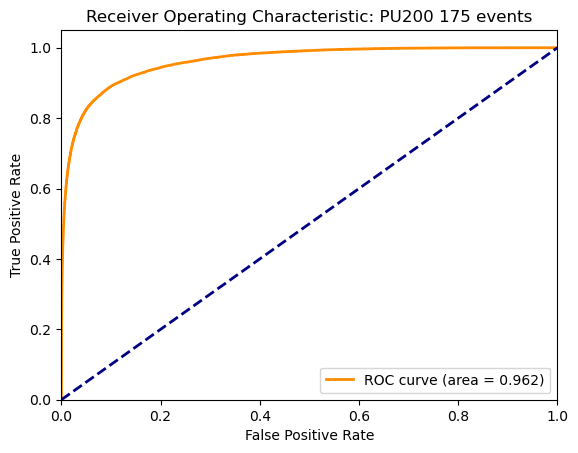

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: PU200 175 events')
plt.legend(loc="lower right")
plt.show()

Prediction scores:
Mean score: 0.0105
Median score: 0.0006


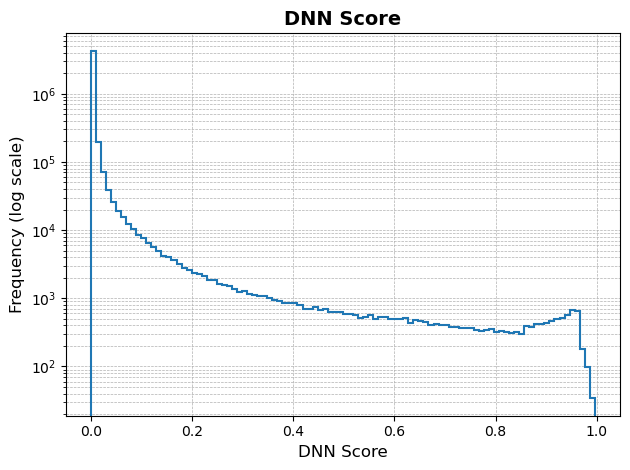

In [10]:
# Get model predictions
# probabilities = model_outputs(filtered_inputs, model)



# Calculate statistics for displaced tracks
# loweta_predictions = probabilities[np.all(mask, axis=1)]
mean_score = np.mean(probabilities)
median_score = np.median(probabilities)

print(f"Prediction scores:")
print(f"Mean score: {mean_score:.4f}")
print(f"Median score: {median_score:.4f}")

plt.hist(probabilities, bins=100, histtype='step', linewidth=1.5)  # Outline only, no fill
plt.yscale('log')
plt.xlabel("DNN Score", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("DNN Score", fontsize=14, weight='bold')

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-0.1938530f, -1.6106808f, -0.9793485f, -1.2317686f, -0.1720161f, -0.1089247f, -0.2165194f, 0.0363943f, 1.3584901f, -2.7267990f, -0.2321570f, -3.0648484f, 0.3649260f, 0.2197024f, 0.0392577f, 0.6557668f, 0.1907549f, 0.3963236f, 0.0086576f, -0.2301822f, -1.5745945f, 1.0811738f, -0.2439629f, -0.1208644f, 0.0785669f, 0.3751839f, -0.0231161f, 2.5385480f, -0.0546612f, 0.2792113f, 3.2879782f, -2.9836135f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[15][32] = {
{ -1.5783896f, -0.0197434f, 1.0018859f, -1.8963747f, 0.1913050f, 0.2548190f, -0.3103749f, -0.1500776f, -4.9278131f, -1.1818948f, -0.0643470f, -0.5166049f, -1.4782641f, -0.0035541f, 0.1755850f, 0.0143971f, -0.1920800f, 0.3206051f, 0.1518826f, -0.5012313f, 1.4542836f, -0.0395743f, -0.0053149f, -0.0654501f, -0.1598596f, 0.2541514f, -0.0068226f, -1.5358663f, 0.0043672f, 1.5508921f, 0.7569684f, -3.1345179f },
{ -0.0323230f, -1.1788718f, 0.0420306f, -3.8412571f, -0.197246

In [12]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

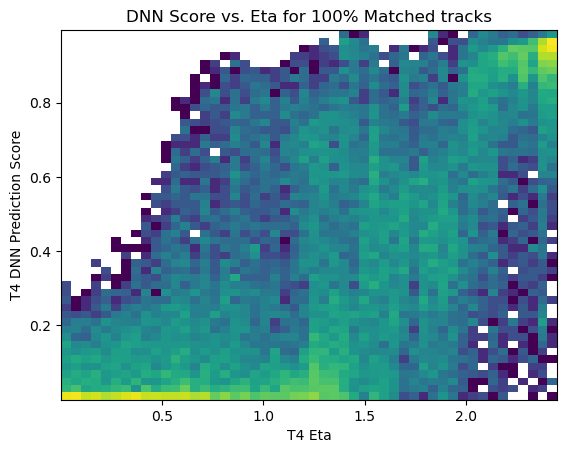

In [13]:
from matplotlib.colors import LogNorm

full_tracks = (np.concatenate(branches['t4_isFake']) == 0) * (np.concatenate(branches['t4_pMatched']) > 0.95) 
plt.hist2d(eta_list[0][full_tracks], predictions[full_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T4 Eta")
plt.ylabel("T4 DNN Prediction Score")
plt.title("DNN Score vs. Eta for 100% Matched tracks")
# plt.colorbar()
plt.show()

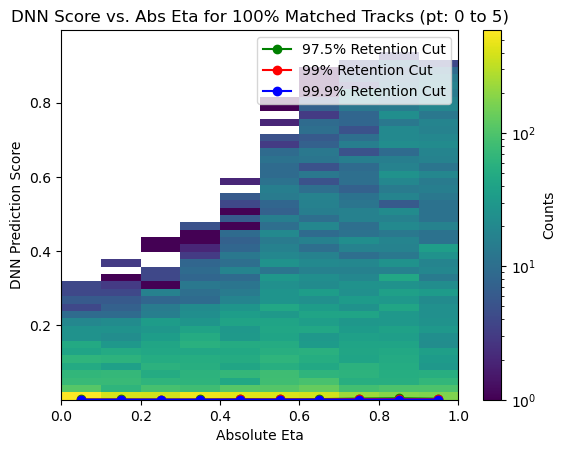

pt: 0 to 5
97.5% Retention Cut: {0.0007, 0.0007, 0.0006, 0.0006, 0.0016, 0.0013, 0.0017, 0.0031, 0.0039, 0.0027} Mean: 0.0017
99% Retention Cut: {0.0004, 0.0004, 0.0003, 0.0004, 0.0006, 0.0008, 0.0004, 0.0017, 0.0016, 0.0014} Mean: 0.0008
99.9% Retention Cut: {1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 0.0002, 0.0005, 0.0005, 0.0004} Mean: 0.0002


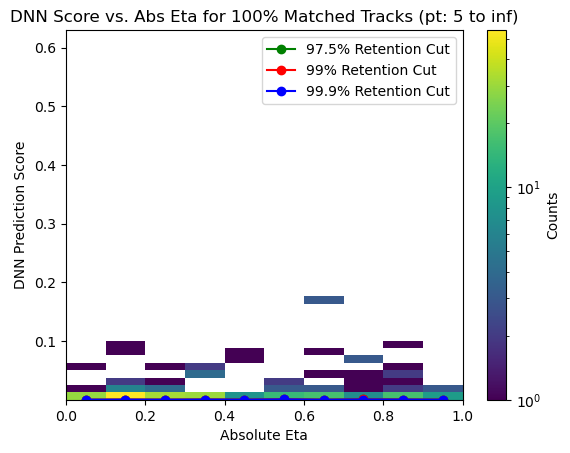

pt: 5 to inf
97.5% Retention Cut: {0.0, 0.0002, 1e-04, 0.0003, 1e-04, 0.0006, 0.0, 0.0006, 0.0002, 0.0} Mean: 0.0002
99% Retention Cut: {0.0, 0.0002, 1e-04, 0.0003, 1e-04, 0.0006, 0.0, 0.0004, 0.0002, 0.0} Mean: 0.0002
99.9% Retention Cut: {0.0, 1e-04, 1e-04, 0.0002, 1e-04, 0.0006, 0.0, 0.0003, 0.0002, 0.0} Mean: 0.0002


In [15]:

# Define pt bins and eta bin edges
pt_bins = [0, 5, np.inf]
# eta_bin_edges = np.arange(0, 2.75, 0.25)
eta_bin_edges = np.arange(0, 1.1, 0.1)

# Function to calculate cut values and plot for a given pt bin
def plot_for_pt_bin(pt_min, pt_max):
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['t4_pt']) > pt_min) & (np.concatenate(branches['t4_pt']) <= pt_max)]
    # abs_eta = eta_list_filtered[full_tracks_filtered & (pt_filtered > pt_min) & (pt_filtered <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t4_pt']) > pt_min) & (np.concatenate(branches['t4_pt']) <= pt_max)]
    # predictions_filtered = predictions[full_tracks_filtered & (pt_filtered > pt_min) & (pt_filtered <= pt_max)]
    # Lists to store cut values for different percentiles
    cut_values_96 = []
    cut_values_97 = []
    cut_values_99 = []
    cut_values_99_9 = []
    cut_values_99_5 = []

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        cut_value_96 = np.percentile(bin_predictions, 4)
        cut_value_97 = np.percentile(bin_predictions, 2.5)
        cut_value_99 = np.percentile(bin_predictions, 1)
        cut_value_99_5 = np.percentile(bin_predictions, 0.5)
        cut_value_99_9 = np.percentile(bin_predictions, 0.1)
        
        # Store the cut values
        cut_values_96.append(cut_value_96)
        cut_values_97.append(cut_value_97)
        cut_values_99.append(cut_value_99)
        cut_values_99_9.append(cut_value_99_9)
        cut_values_99_5.append(cut_value_99_5)

    # Plot 2D histogram
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    plt.plot(cut_x, cut_values_97, 'g-', marker='o', label='97.5% Retention Cut')
    plt.plot(cut_x, cut_values_99, 'r-', marker='o', label='99% Retention Cut')
    plt.plot(cut_x, cut_values_99_9, 'b-', marker='o', label='99.9% Retention Cut')
    plt.legend()
    
    plt.show()
    
    # Print the cut values
    print(f"pt: {pt_min} to {pt_max}")
    print("97.5% Retention Cut:", '{' + ', '.join(str(x) for x in np.round(cut_values_97, 4)) + '}', "Mean:", np.round(np.mean(cut_values_97), 4))
    print("99% Retention Cut:", '{' + ', '.join(str(x) for x in np.round(cut_values_99, 4)) + '}', "Mean:", np.round(np.mean(cut_values_99), 4))
    print("99.9% Retention Cut:", '{' + ', '.join(str(x) for x in np.round(cut_values_99_9, 4)) + '}', "Mean:", np.round(np.mean(cut_values_99_9), 4))


# Plot for each pt bin
for i in range(len(pt_bins) - 1):
    plot_for_pt_bin(pt_bins[i], pt_bins[i + 1])
